In [1]:
import sys

sys.path.append('/projectnb/textconv/llama/packages')

import fairscale
import os
import torch

In [2]:
from fairscale.nn.model_parallel.initialize import (
    get_model_parallel_rank,
    initialize_model_parallel,
    model_parallel_is_initialized,
)

In [3]:
from llama.generation import Llama, Dialog
from llama.model import ModelArgs, Transformer
from llama.tokenizer import Tokenizer

In [4]:


# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of CUDA devices
    num_cuda_devices = torch.cuda.device_count()
    print(f"Number of CUDA devices available: {num_cuda_devices}")

    # List the properties of each CUDA device
    for i in range(num_cuda_devices):
        device = torch.device(f'cuda:{i}')
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available on this system.")

Number of CUDA devices available: 1
Device 0: Tesla V100-PCIE-16GB


In [5]:

os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '8888' #since i am doing my llama stuff already haha
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
#os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [6]:
generator = Llama.build(
        ckpt_dir="llama-2-7b/",
        tokenizer_path="tokenizer.model",
        max_seq_len=512, #max_seq_len....
        max_batch_size=6,
    )

> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1
Loaded in 30.44 seconds


torchrun --nproc_per_node 1 example_text_completion.py \
    --ckpt_dir llama-2-7b/ \
    --tokenizer_path tokenizer.model \
    --max_seq_len 128 --max_batch_size 4
    

In [7]:
generator.tokenizer

In [ ]:
##you probs gotta kill something if you came from the other llama sheet.

In [7]:
prompt_tokens = generator.tokenizer.encode(
                        f"This essay was totally written by a person.",
                        bos=True,
                        eos=True,
                    )

In [8]:
prompt_tokens = [prompt_tokens]

In [9]:
prompt_tokens

[[1, 910, 3686, 388, 471, 14909, 3971, 491, 263, 2022, 29889, 2]]

In [10]:
total_len = generator.model.params.max_seq_len

pad_id = generator.tokenizer.pad_id 
bsz = len(prompt_tokens)
tokens = torch.full((bsz, total_len), pad_id, dtype=torch.long, device="cuda")
for k, t in enumerate(prompt_tokens):
    tokens[k, : len(t)] = torch.tensor(t, dtype=torch.long, device="cuda")

In [11]:
tokens

tensor([[    1,   910,  3686,   388,   471, 14909,  3971,   491,   263,  2022,
         29889,     2,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,  

In [13]:
######
i = 6
model_result = generator.model.forward(tokens[:,0:i],0) #if i pass in 9 tokens, it is spitting out 9 tokens.  
last_logits = model_result[:, -1]  ###this is where we could put temperature. https://github.com/facebookresearch/llama/blob/main/llama/generation.py#L192 
vocab_dim = 32_000
data_tensor = last_logits
sorted_data, _ = data_tensor.sort(dim=1, descending=True)
indices_tensor = tokens[:,i+1].unsqueeze(0)
print(indices_tensor)
print(data_tensor.shape, sorted_data.shape,indices_tensor.shape )
ranks = torch.where(sorted_data == data_tensor.gather(1, indices_tensor), torch.arange(1, vocab_dim + 1).unsqueeze(0), torch.zeros(1))
ranks = torch.max(ranks,axis =-1).values
print(ranks)

tensor([[491]])
torch.Size([1, 32000]) torch.Size([1, 32000]) torch.Size([1, 1])
tensor([102.])


In [16]:
tokens[:,0:i]

tensor([[    1,   910,  3686,   388,   471, 14909]])

In [20]:
generator.model.forward(torch.tensor(prompt_tokens),0)[:, -1].shape

torch.Size([1, 32000])

In [51]:
prompt_tokens = generator.tokenizer.encode(
                        f"This essay was totally written by a person.",
                        bos=True,
                        eos=True,
                    )
prompt_tokens = [prompt_tokens]

def tokenize_sentence(sentence):
    prompt_tokens = generator.tokenizer.encode(
                        sentence,
                        bos=True,
                        eos=True,
    )
    return torch.tensor([prompt_tokens])

def selection_tensor(model, indices, vocab_dim = 32_000):
    """
    model will be llama, give it generator.model, and indices should be a tensor of batch 1
    so will look like tensor([[    1,   910,  3686,   388}]])
    not sure we can vectorize this?
    """
    rank_list = []
    seq_len = len(indices[0])
    
    #i think these are right, all the indexing.  allow the prints to prove it.
    
    for i in range(1,seq_len): #maybe we skip the first one? idk ask the boyz
        
        #print(indices[:,0:i],indices[:,i])
        
        model_result = model.forward(indices[:,0:i],0) 
        data_tensor = model_result[:, -1]  #temperature here if you wana
        sorted_data, _ = data_tensor.sort(dim=1, descending=True)
        indices_tensor = indices[:,i].unsqueeze(0) #get the next token, to compare to the model result
        ranks = torch.where(sorted_data == data_tensor.gather(1, indices_tensor), torch.arange(1, vocab_dim + 1).unsqueeze(0), torch.zeros(1))
        ranks = int(torch.max(ranks,axis =-1).values)
        rank_list.append(ranks)
    return rank_list

def large_selection_tensor(model, indices, vocab_dim = 32_000, max_seq_len=512):
    """
    model will be llama, give it generator.model, and indices should be a tensor of batch 1
    so will look like tensor([[    1,   910,  3686,   388}]])
    not sure we can vectorize this?
    """
    rank_list = []
    seq_len = len(indices[0])
    
    #i think these are right, all the indexing.  allow the prints to prove it.
    
    for i in range(1,seq_len): #maybe we skip the first one? idk ask the boyz
        
        #print(indices[:,0:i],indices[:,i])
        
        start_idx = max(0,i-max_seq_len)
        
        model_result = model.forward(indices[:,start_idx:i],0) 
        #print(start_idx, model_result.shape)
        data_tensor = model_result[:, -1]  #temperature here if you wana
        sorted_data, _ = data_tensor.sort(dim=1, descending=True)
        indices_tensor = indices[:,i].unsqueeze(0) #get the next token, to compare to the model result
        ranks = torch.where(sorted_data == data_tensor.gather(1, indices_tensor), torch.arange(1, vocab_dim + 1).unsqueeze(0), torch.zeros(1))
        ranks = int(torch.max(ranks,axis =-1).values)
        rank_list.append(ranks)
    return rank_list

def process_essay(essay_text, model):
    essay_tokens = tokenize_sentence(essay_text)
    idx_list = large_selection_tensor(model, essay_tokens)
    return idx_list

def process_essays(model, input_df, result_file):
    try:
        # Load the existing result file if it exists
        new_df = pd.read_csv(result_file)
        processed_ids = set(new_df["id"].tolist())
    except FileNotFoundError:
        # If the file doesn't exist, create an empty DataFrame and dictionary
        new_df = pd.DataFrame(columns=["id", "indexes"])
        processed_ids = {}

    # Iterate through the original DataFrame
    for index, row in input_df.iterrows():
        essay_id = row["id"]
        essay_text = row["text"]

        # Check if the ID has already been processed
        if essay_id in processed_ids:
            print(f"ID {essay_id} has already been processed. Skipping...")
            continue

        try:
            # Process the essay text
            indexes = process_essay(essay_text, model)
            max_idx = new_df.index.max()
            write_idx = max_idx + 1
            new_df.loc[write_idx] = [str(essay_id),indexes]
            new_df.to_csv(result_file, index=False)
            processed_ids.add(essay_id)
            
            print(f"Processed ID {essay_id} successfully.")

        except Exception as e:
            print(f"Error processing ID {essay_id}: {str(e)}")

    # After processing all essays, save the final new DataFrame
    new_df.to_csv(result_file, index=False)

In [55]:
import pandas as pd
import random
import string

# Create a list of unique IDs
ids = [1, 2, 3,4,5,6,7,8,9,10]

# Generate random text for the "text" column


text_data = ["new text" for _ in range(len(ids))]

# Create the DataFrame
data = {'id': ids, 'text': text_data}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

   id      text
0   1  new text
1   2  new text
2   3  new text
3   4  new text
4   5  new text
5   6  new text
6   7  new text
7   8  new text
8   9  new text
9  10  new text


6

In [50]:
df.loc[12] = ['8',[1,2,3,4]]
print(df)

   id                                               text
0   1  Hi this is a pretend essay baby. and this is m...
1   2  Hi this is a pretend essay baby. and this is m...
2   3  Hi this is a pretend essay baby. and this is m...
3   4  Hi this is a pretend essay baby. and this is m...
4   5  Hi this is a pretend essay baby. and this is m...
5   6  Hi this is a pretend essay baby. and this is m...
6   7  Hi this is a pretend essay baby. and this is m...
11  8                                          [1, 2, 3]
12  8                                       [1, 2, 3, 4]


In [43]:
max_id = df['id'].max()
max_id

7

In [56]:
process_essays(generator.model, input_df = df, result_file = "teste_res.csv")

ID 1 has already been processed. Skipping...
ID 2 has already been processed. Skipping...
ID 3 has already been processed. Skipping...
ID 4 has already been processed. Skipping...
ID 5 has already been processed. Skipping...
ID 6 has already been processed. Skipping...
ID 7 has already been processed. Skipping...
Processed ID 8 successfully.
Processed ID 9 successfully.
Processed ID 10 successfully.


In [57]:
x = pd.read_csv("teste_res.csv")
x

,id,indexes
0,1,"[190, 27, 1, 2, 2160, 1, 126, 1, 2346, 1, 92, ..."
1,2,"[190, 27, 1, 2, 2160, 1, 126, 1, 2346, 1, 92, ..."
2,3,"[190, 27, 1, 2, 2160, 1, 126, 1, 2346, 1, 92, ..."
3,4,"[190, 27, 1, 2, 2160, 1, 126, 1, 2346, 1, 92, ..."
4,5,"[190, 27, 1, 2, 2160, 1, 126, 1, 2346, 1, 92, ..."
5,6,"[190, 27, 1, 2, 2160, 1, 126, 1, 2346, 1, 92, ..."
6,7,"[190, 27, 1, 2, 2160, 1, 126, 1, 2346, 1, 92, ..."
7,8,"[1368, 388, 979]"
8,9,"[1368, 388, 979]"
9,10,"[1368, 388, 979]"


In [58]:
x.to_json('data.json', orient='records')

In [21]:
sentence = "our theory is just that a person writing a sentence has a less predictable selection"
test_tokens = tokenize_sentence(sentence)
print(test_tokens)
selection_tensor(generator.model,test_tokens)

tensor([[    1,  1749,  6368,   338,   925,   393,   263,  2022,  5007,   263,
         10541,   756,   263,  3109,  8500,   519,  9262,     2]])


[3120, 3092, 2, 28, 2, 11, 8, 287, 1, 44, 6, 2, 506, 113, 1, 189, 361]

In [22]:
# should do it in one call
process_essay(sentence, generator.model) #beautiful

[3120, 3092, 2, 28, 2, 11, 8, 287, 1, 44, 6, 2, 506, 113, 1, 189, 361]

In [16]:
sentence = pokemon_essay
test_tokens = tokenize_sentence(sentence)
pokemon_list = large_selection_tensor(generator.model, test_tokens)
#selection_tensor(generator.model,test_tokens)

In [18]:
len(pokemon_list)

924

In [15]:
pokemon_essay = """
The World of Pokémon: Exploring the Fascination of These Fascinating Creatures

Pokémon, short for Pocket Monsters, is a global phenomenon that has captivated the hearts and minds of people of all ages since its inception in the late 1990s. While the Pokémon franchise encompasses various aspects, such as video games, trading cards, an animated TV series, and merchandise, at the heart of it all are the intriguing and diverse creatures known as Pokémon. These fictional creatures have proven to be more than just collectible characters; they are a rich source of interest and fascination, both for their unique characteristics and the deeper themes they represent.

One of the most intriguing aspects of Pokémon is the sheer diversity of these creatures. With over 800 different species of Pokémon, each possessing distinct abilities, types, and appearances, there is an endless variety for fans to explore and engage with. From the fire-breathing Charizard to the enigmatic Psychic-type Mewtwo, every Pokémon is a unique entity with its own set of strengths and weaknesses. This diversity fosters a sense of discovery and curiosity as players and fans strive to learn more about these fantastical creatures.

Furthermore, the concept of capturing and training Pokémon adds an element of personal connection and growth to the franchise. Trainers, the individuals in the Pokémon world who catch and raise these creatures, develop bonds with their Pokémon akin to the relationships between pet owners and their animals in the real world. This bond goes beyond mere gameplay mechanics; it's a testament to the emotional depth and complexity that the franchise offers. The process of nurturing and evolving Pokémon mirrors personal growth, and many players find themselves invested in the development of their virtual companions.

Beyond their role as collectible creatures, Pokémon also serve as powerful symbols of themes like friendship, teamwork, and environmental awareness. The central ethos of the Pokémon world is encapsulated in the phrase Gotta Catch 'Em All, which encourages players to explore, connect, and collaborate with others in their quest to complete the Pokédex, an encyclopedia of Pokémon species. This emphasis on camaraderie and cooperation has made Pokémon a vehicle for teaching valuable life lessons about the importance of working together to achieve common goals.

Pokémon also delves into complex moral and ethical dilemmas. For instance, the game often confronts players with the question of whether it is right to capture and battle these creatures for personal gain. It encourages players to consider the well-being of the Pokémon and the consequences of their actions. These ethical quandaries stimulate critical thinking and promote discussions about the responsibilities that come with power and ambition.

Another fascinating aspect of Pokémon is its ability to adapt and evolve with the times. The franchise has continued to innovate and expand, introducing new generations of Pokémon with each installment. It has successfully transitioned into augmented reality with the mobile game Pokémon GO, which brought the world of Pokémon into the real world. This adaptability ensures that Pokémon remains relevant and engaging for new generations of fans while retaining its nostalgic appeal for long-time enthusiasts.

In conclusion, Pokémon is not merely a collection of interesting creatures but a cultural phenomenon that has endured for decades. Its enduring popularity can be attributed to the captivating diversity of its creatures, the emotional connections forged between trainers and their Pokémon, and the powerful themes it explores. Pokémon serves as a reminder of the value of exploration, friendship, and ethical reflection. As the franchise continues to evolve and grow, it will undoubtedly continue to capture the imaginations of people worldwide, making these fascinating creatures an enduring part of our cultural landscape.
"""


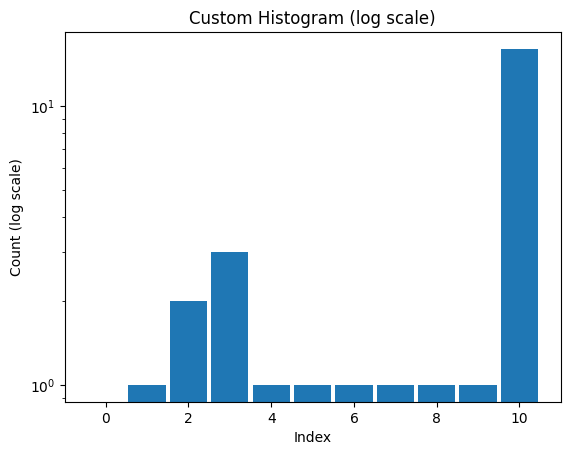

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def custom_histogram(indexes, max_bin):
    # Count the occurrences of each index
    counts = np.bincount(indexes)

    # Create bins up to max_bin
    bins = np.arange(max_bin + 1)

    # Merge the counts above max_bin into the final bin
    if len(counts) > max_bin + 1:
        counts[max_bin] += sum(counts[max_bin + 1:])
        counts = counts[:max_bin + 1]

    # Plot the histogram
    plt.bar(bins, counts, align='center', width=0.9)
    plt.xlabel('Index')
    plt.ylabel('Count')
    plt.title('Custom Histogram')
    plt.show()

# Example usage



def custom_histogram_log(indexes, max_bin, title="suck nuts"):
    # Count the occurrences of each index
    counts = np.bincount(indexes)

    # Create bins up to max_bin
    bins = np.arange(max_bin + 1)

    # Merge the counts above max_bin into the final bin
    if len(counts) > max_bin + 1:
        counts[max_bin] += sum(counts[max_bin + 1:])
        counts = counts[:max_bin + 1]

    # Plot the histogram on a logarithmic scale (base 10)
    plt.bar(bins, counts, align='center', width=0.9)
    plt.yscale('log')  # Set the y-axis to a logarithmic scale
    plt.xlabel('Index')
    plt.ylabel('Count (log scale)')
    plt.title(title)
    plt.show()

# Example usage
indexes = [1, 2, 2, 3, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
max_bin = 10
title = 'Custom Histogram (log scale)'
custom_histogram_log(indexes, max_bin, title)

In [ ]:
max_bin = 100
custom_histogram(pokemon_list, max_bin)

In [35]:
human_test = """Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article, "Paris bans driving due to smog," by Robert Duffer says, how Paris, after days of nearrecord pollution, enforced a partial driving ban to clear the air of the global city. It also says, how on Monday, motorist with evennumbered license plates were ordered to leave their cars at home or be fined a 22euro fine 31. The same order would be applied to oddnumbered plates the following day. Cars are the reason for polluting entire cities like Paris. This shows how bad cars can be because, of all the pollution that they can cause to an entire city.

Likewise, in the article, "Carfree day is spinning into a big hit in Bogota," by Andrew Selsky says, how programs that's set to spread to other countries, millions of Columbians hiked, biked, skated, or took the bus to work during a carfree day, leaving streets of this capital city eerily devoid of traffic jams. It was the third straight year cars have been banned with only buses and taxis permitted for the Day Without Cars in the capital city of 7 million. People like the idea of having carfree days because, it allows them to lesson the pollution that cars put out of their exhaust from people driving all the time. The article also tells how parks and sports centers have bustled throughout the city uneven, pitted sidewalks have been replaced by broad, smooth sidewalks rushhour restrictions have dramatically cut traffic and new restaurants and upscale shopping districts have cropped up. Having no cars has been good for the country of Columbia because, it has aloud them to repair things that have needed repairs for a long time, traffic jams have gone down, and restaurants and shopping districts have popped up, all due to the fact of having less cars around.

In conclusion, the use of less cars and having carfree days, have had a big impact on the environment of cities because, it is cutting down the air pollution that the cars have majorly polluted, it has aloud countries like Columbia to repair sidewalks, and cut down traffic jams. Limiting the use of cars would be a good thing for America. So we should limit the use of cars by maybe riding a bike, or maybe walking somewhere that isn't that far from you and doesn't need the use of a car to get you there. To me, limiting the use of cars might be a good thing to do.
"""

In [39]:
sentence = human_test
test_tokens = tokenize_sentence(sentence)
human_list = large_selection_tensor(generator.model, test_tokens)

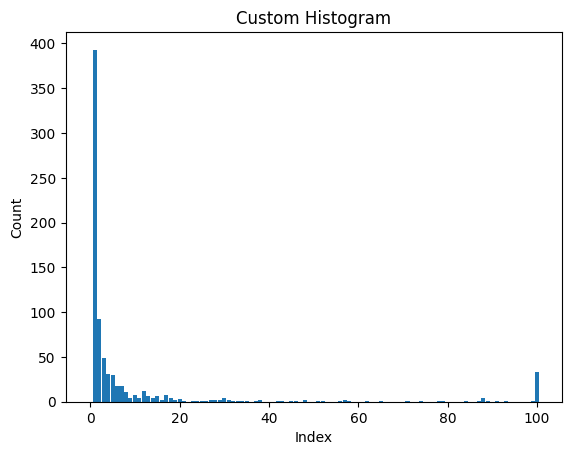

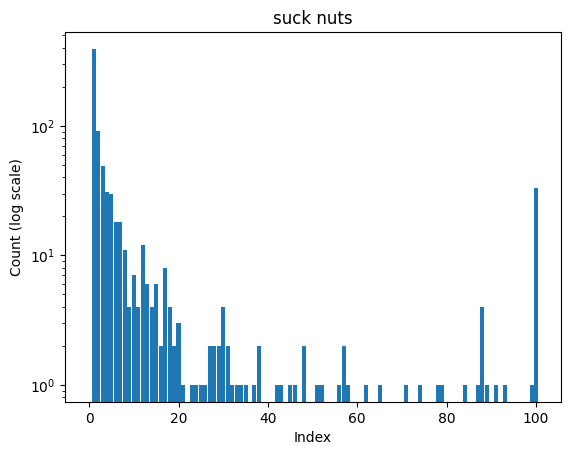

In [42]:
custom_histogram(human_list, max_bin = 100)
custom_histogram_log(human_list, max_bin = 100)

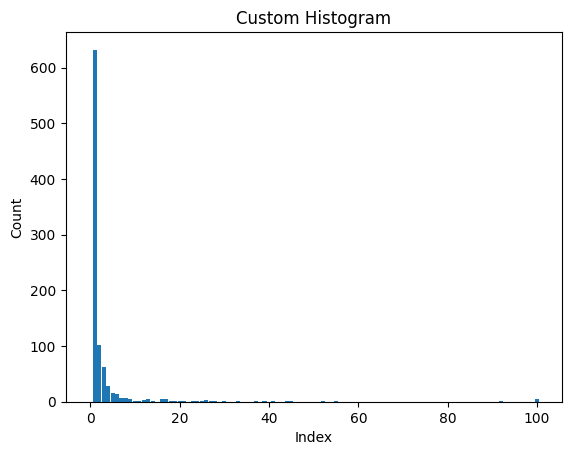

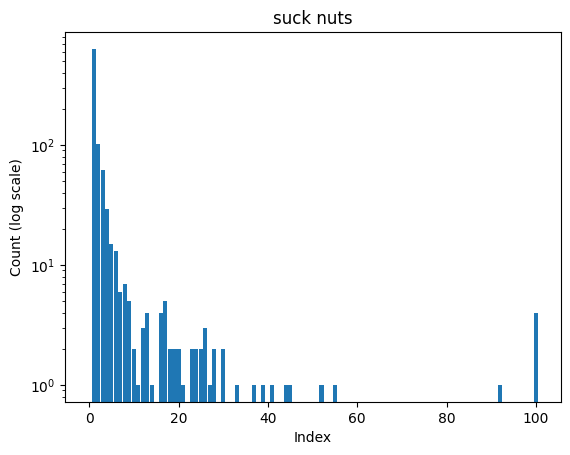

In [43]:
custom_histogram(pokemon_list, max_bin = 100)
custom_histogram_log(pokemon_list, max_bin = 100)

In [51]:
model_result[:, -1] ###this is just the last in the sequence. 

tensor([[-8.9141, -8.6406,  2.7539,  ..., -3.9766, -5.2070, -3.9004]],
       dtype=torch.float32)

In [48]:
next_token = torch.argmax(model_result[:, -1], dim=-1)

In [49]:
next_token,model_result

(tensor([263]),
 tensor([[[-1.2828e+01, -7.4570e+00, -4.6582e-01,  ..., -6.7812e+00,
           -8.0156e+00, -7.5039e+00],
          [-1.3914e+01, -1.1062e+01, -4.8047e+00,  ..., -8.3672e+00,
           -9.4219e+00, -9.1250e+00],
          [-2.8477e+00,  1.8301e+00,  8.7969e+00,  ...,  4.0508e+00,
            2.0977e+00,  2.4121e+00],
          ...,
          [-7.7773e+00, -7.9727e+00,  3.7578e+00,  ..., -2.1641e+00,
           -5.0156e+00, -1.3154e+00],
          [-4.8945e+00, -5.1133e+00,  6.8711e+00,  ..., -3.6016e+00,
           -2.1016e+00, -8.6365e-03],
          [-8.9141e+00, -8.6406e+00,  2.7539e+00,  ..., -3.9766e+00,
           -5.2070e+00, -3.9004e+00]]], dtype=torch.float32))

In [50]:
for i in torch.argmax(model_result,axis = -1)[0]:
    print(i,generator.tokenizer.sp_model.id_to_piece(int(i)))

tensor(917) ▁Tags
tensor(338) ▁is
tensor(388) ay
tensor(338) ▁is
tensor(10437) ▁originally
tensor(20603) ▁inspired
tensor(491) ▁by
tensor(263) ▁a


In [27]:
print(model_result.shape)
torch.argmax(model_result, axis =-1)

torch.Size([1, 9, 32000])


tensor([[  917,   338,   388,   338, 10437, 20603,   491,   263,  9225]])

In [18]:
piece = generator.tokenizer.sp_model.id_to_piece(910)
piece

'▁This'

In [105]:
dir(generator)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'build',
 'chat_completion',
 'generate',
 'model',
 'text_completion',
 'tokenizer']

In [ ]:
prompts: List[str],
        temperature: float = 0.6,
        top_p: float = 0.9,
        max_gen_len: Optional[int] = None,
        logprobs: bool = False,
        echo: bool = False,

In [28]:
generator.text_completion(prompts=["hi there. write something",'whats good bitch ass mother'],temperature=0,max_gen_len=2,logprobs=True)
#this is what i have to match essentially.  oh no, reduce temperature.  

[{'generation': '.\n',
  'tokens': ['.', '\n'],
  'logprobs': [-1.8350802659988403, -0.7871227264404297]},
 {'generation': 'fuck',
  'tokens': ['f', 'uck'],
  'logprobs': [-0.46609020233154297, -0.684036135673523]}]

In [81]:

batch_size = 1
vocab_dim = 5

data_tensor = torch.rand((batch_size, vocab_dim))

# Create a tensor of indices
indices_tensor = torch.randint(0, vocab_dim, (batch_size, 1))
#print(indices_tensor)
# Sort the data tensor along the appropriate dimension in descending order
sorted_data, _ = data_tensor.sort(dim=1, descending=True)

print(data_tensor.shape, sorted_data.shape,indices_tensor.shape )
# Use torch.where to find the ranks of the indices
ranks = torch.where(sorted_data == data_tensor.gather(1, indices_tensor), torch.arange(1, vocab_dim + 1).unsqueeze(0), torch.zeros(1))

# Convert ranks to a tensor of shape batch_size x 1

print(data_tensor,indices_tensor)
print(ranks)
ranks = torch.max(ranks,axis =-1).values

torch.Size([1, 5]) torch.Size([1, 5]) torch.Size([1, 1])
tensor([[0.4529, 0.5381, 0.9604, 0.7471, 0.8032]]) tensor([[0]])
tensor([[0., 0., 0., 0., 5.]])


In [70]:
ranks

tensor([3., 1., 3., 3.])